# Pipeline 1: Predicting Volatility and Evaluation

In [2]:
import os
import time
import random
import warnings
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import backend as K
import gc

import src.util as util
import src.rv as rv
import src.lstm as lstm

warnings.filterwarnings("ignore")

importlib.reload(util)
importlib.reload(rv)
importlib.reload(lstm)

SEED = 3888
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

df_single_stock = combined_df[combined_df["stock_id"] == 50200].copy()

snapshot_features_df = util.create_snapshot_features(df_single_stock)
snapshot_features_df = snapshot_features_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

In [4]:
subset_time_ids = snapshot_features_df['time_id'].unique()[:50]
subset_snapshot_df = snapshot_features_df[snapshot_features_df['time_id'].isin(subset_time_ids)].copy()

In [ ]:
importlib.reload(util)
rolling_features_df = util.generate_rolling_features(subset_snapshot_df)

## RV WLS Baseline

=== HAR-RV WLS Baseline Evaluation ===
MSE: 0.00000000
RMSE: 0.00005804
QLIKE: 0.3934
Directional Accuracy: 0.5050
✅ Model saved to out/rv/har_wls.pkl


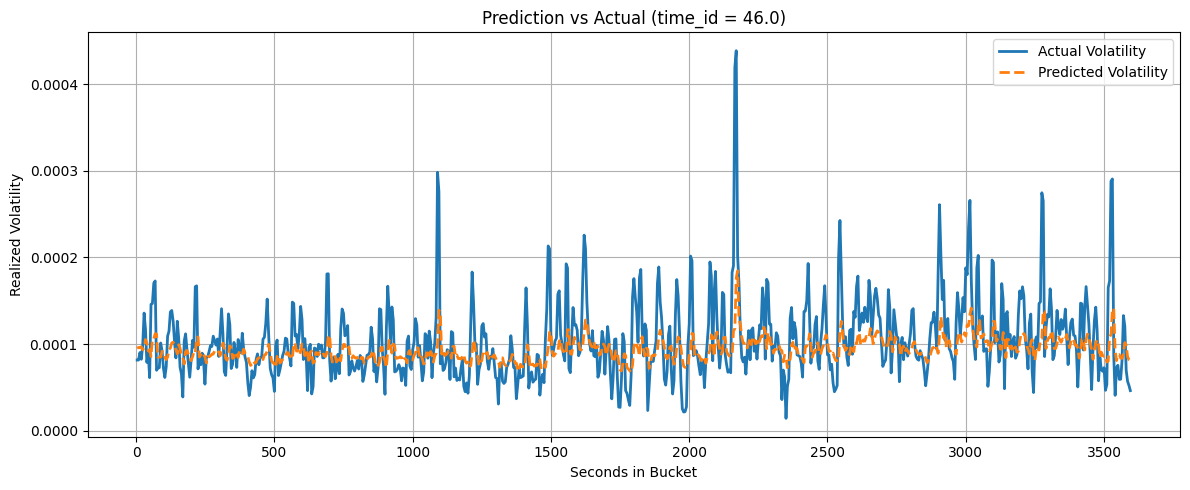

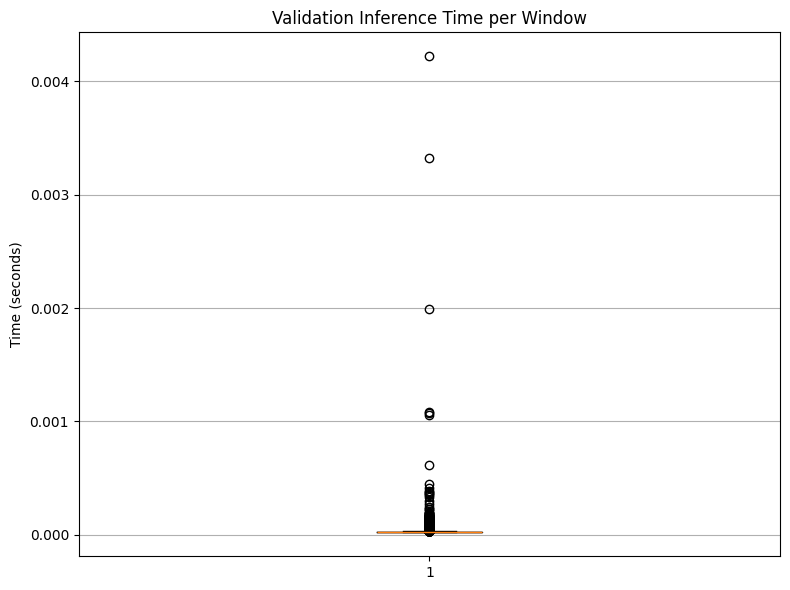

,time_id,start_time,y_true,y_pred,inference_time
0,46.0,4.0,0.000082,0.000095,0.000081
1,46.0,9.0,0.000082,0.000096,0.000039
2,46.0,14.0,0.000090,0.000096,0.000034
3,46.0,19.0,0.000083,0.000097,0.000032
4,46.0,24.0,0.000099,0.000093,0.000031
5,46.0,29.0,0.000136,0.000096,0.000030
6,46.0,34.0,0.000117,0.000105,0.000034
7,46.0,39.0,0.000079,0.000101,0.004222
8,46.0,44.0,0.000089,0.000092,0.000063
9,46.0,49.0,0.000061,0.000094,0.000036


In [ ]:
importlib.reload(rv)

model_rv_wls, test_df_wls = rv.wls(rolling_features_df)

util.plot_prediction_vs_actual(
    df=test_df_wls,
    time_id=test_df_wls['time_id'].iloc[0],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(test_df_wls)

display(test_df_wls.head(10))

test_df_wls.to_csv('out/val_df/wls.csv', index=False)

## LSTM

### LSTM Baseline

In [ ]:
importlib.reload(lstm)

model_lstm_baseline, history_lstm_baseline, val_df_lstm_baseline = lstm.baseline(
    snapshot_df=subset_snapshot_df,
    basic_features=['wap', 'log_return'],
    epochs=100,
    batch_size=32,
    learning_rate=1e-4,
    es_patience=20,
    lr_patience=5,
    model_name='baseline'
)

Epoch 1/100


2025-05-21 22:08:33.401557: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-21 22:08:33.401596: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-21 22:08:33.401610: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-21 22:08:33.401628: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-21 22:08:33.401642: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-21 22:08:33.742914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 0.8081 - val_loss: 0.3230 - learning_rate: 1.0000e-04
Epoch 2/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 0.5740 - val_loss: 0.2940 - learning_rate: 1.0000e-04
Epoch 3/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 0.5572 - val_loss: 0.3213 - learning_rate: 1.0000e-04
Epoch 4/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.5483 - val_loss: 0.2988 - learning_rate: 1.0000e-04
Epoch 5/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 0.5385 - val_loss: 0.2876 - learning_rate: 1.0000e-04
Epoch 6/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 0.5485 - val_loss: 0.2786 - learning_rate: 1.0000e-04
Epoch 7/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 0.5565 - val_loss: 0.2778 - learning_rate: 1.0000e-04
Epoch 8/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.5606 - val_loss: 0.2874 - learning_rate: 1.0000e-04
Epoch 9/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 0.5248 - val_

Validation MSE: 0.00000000
Validation RMSE: 0.00003914
Validation QLIKE: 0.3712
Dir Acc: 0.3606
Model & scalers saved to out/lstm


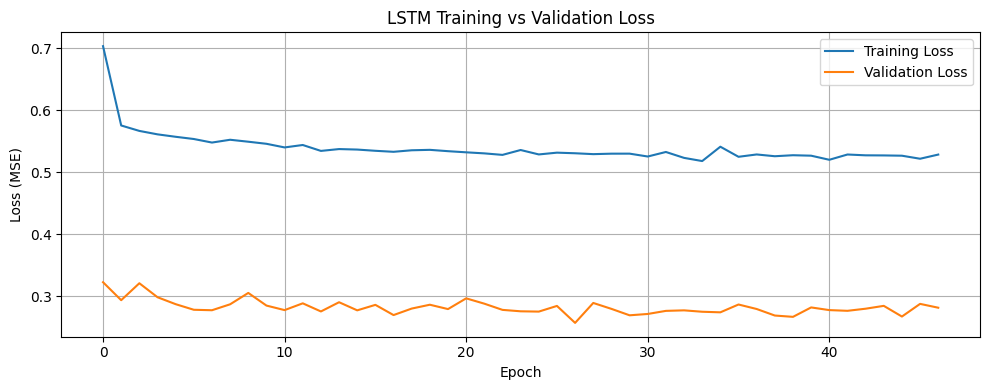

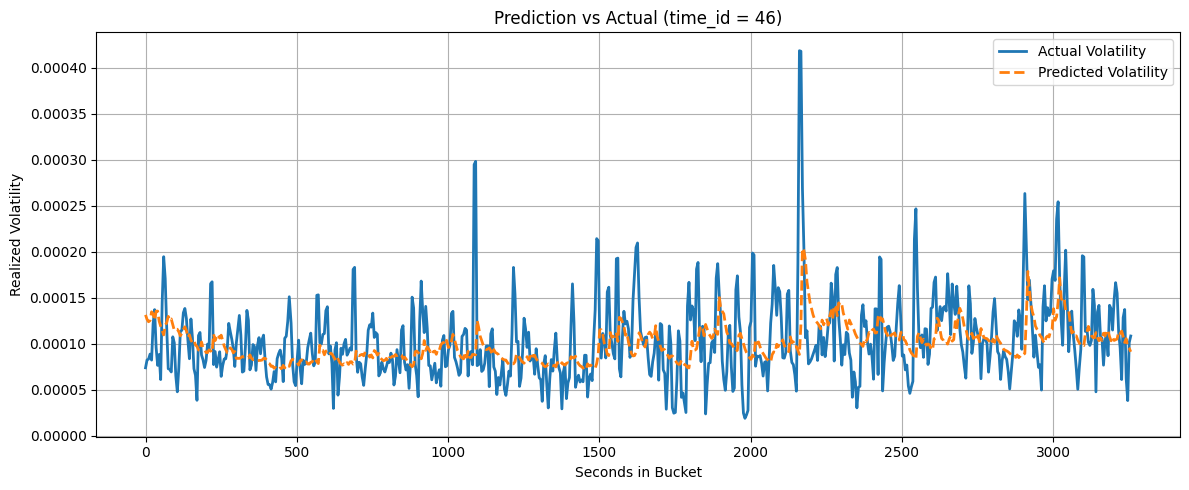

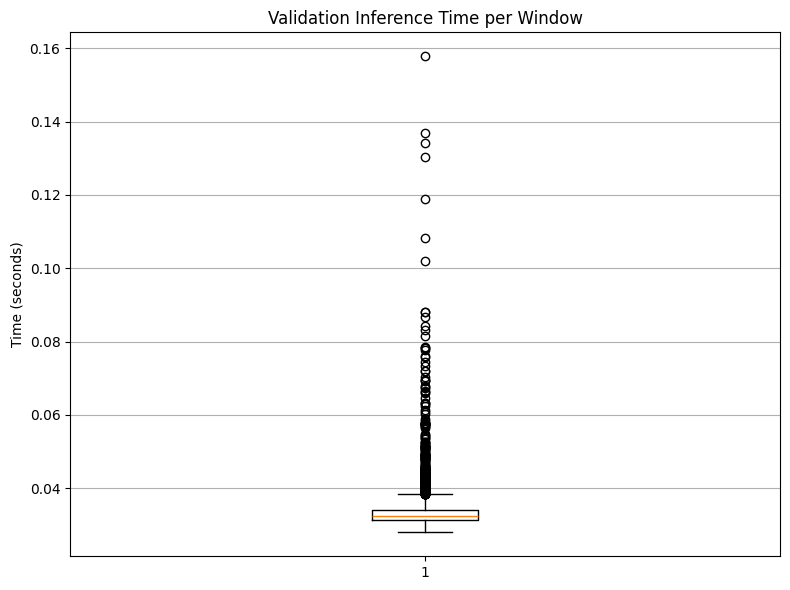

,time_id,start_time,y_true,y_pred,inference_time
0,46,0.0,0.000074,0.000131,0.108254
1,46,5.0,0.000082,0.000126,0.030937
2,46,10.0,0.000083,0.000124,0.034414
3,46,15.0,0.000089,0.000125,0.030995
4,46,20.0,0.000082,0.000135,0.031393
5,46,25.0,0.000121,0.000132,0.031264
6,46,30.0,0.000137,0.000125,0.031190
7,46,35.0,0.000096,0.000135,0.031451
8,46,40.0,0.000076,0.000135,0.033278
9,46,45.0,0.000088,0.000124,0.030891


In [ ]:
util.plot_training_loss(history_lstm_baseline)

util.plot_prediction_vs_actual(
    val_df_lstm_baseline,
    time_id=val_df_lstm_baseline['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(val_df_lstm_baseline)

display(val_df_lstm_baseline.head(10))

val_df_lstm_baseline.to_csv('out/val_df/baseline.csv', index=False)

In [8]:
K.clear_session()
gc.collect()

0

### LSTM with Additional Features

In [ ]:
importlib.reload(lstm)

feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]

model_lstm_features, history_lstm_features, val_df_lstm_features = lstm.baseline(
    snapshot_df=subset_snapshot_df,
    basic_features=feature_cols,
    epochs=100,
    batch_size=32,
    learning_rate=1e-4,
    es_patience=20,
    lr_patience=5,
    model_name='additional_features'
)

Epoch 1/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - loss: 0.6598 - val_loss: 0.3149 - learning_rate: 1.0000e-04
Epoch 2/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - loss: 0.5599 - val_loss: 0.3079 - learning_rate: 1.0000e-04
Epoch 3/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 0.5579 - val_loss: 0.2937 - learning_rate: 1.0000e-04
Epoch 4/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 0.5702 - val_loss: 0.3092 - learning_rate: 1.0000e-04
Epoch 5/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 0.5480 - val_loss: 0.3011 - learning_rate: 1.0000e-04
Epoch 6/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 0.5489 - val_loss: 0.2837 - learning_rate: 1.0000e-04
Epoch 7/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 0.5374 - val_loss: 0.2899 - learning_rate: 1.0000e-04
Epoch 8/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 0.5432 - val_loss: 0.2928 - learning_rate: 1.0000e-04
Epoch 9/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 0

Validation MSE: 0.00000000
Validation RMSE: 0.00003928
Validation QLIKE: 0.3726
Dir Acc: 0.3772
Model & scalers saved to out/lstm


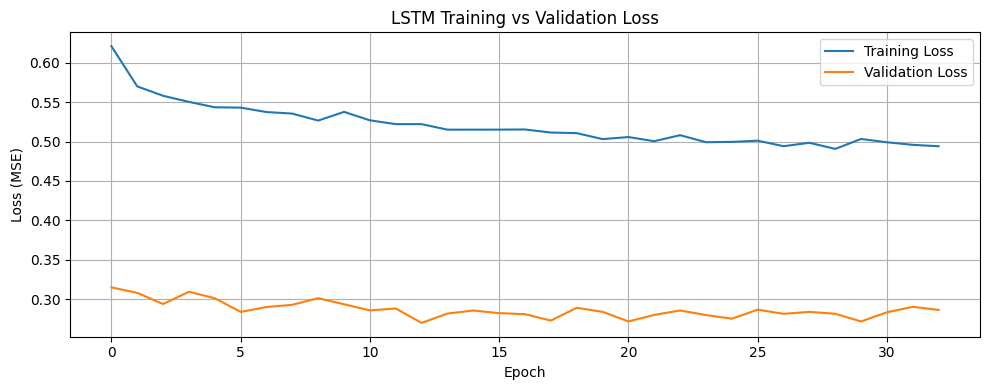

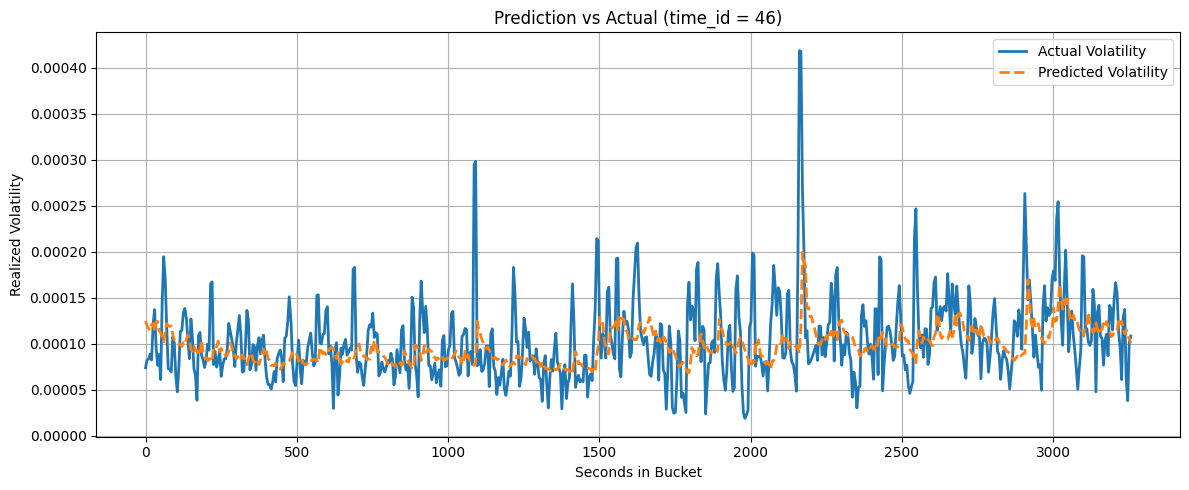

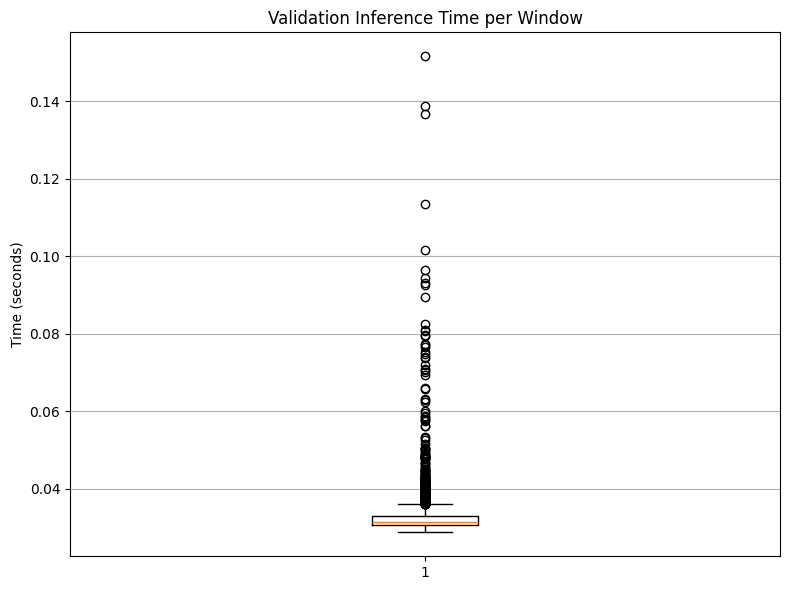

,time_id,start_time,y_true,y_pred,inference_time
0,46,0.0,0.000074,0.000125,0.096443
1,46,5.0,0.000082,0.000120,0.031903
2,46,10.0,0.000083,0.000116,0.030315
3,46,15.0,0.000089,0.000115,0.030847
4,46,20.0,0.000082,0.000121,0.029945
5,46,25.0,0.000121,0.000122,0.030842
6,46,30.0,0.000137,0.000113,0.031023
7,46,35.0,0.000096,0.000124,0.029554
8,46,40.0,0.000076,0.000124,0.030371
9,46,45.0,0.000088,0.000113,0.029624


In [ ]:
util.plot_training_loss(history_lstm_features)

util.plot_prediction_vs_actual(
    val_df_lstm_features,
    time_id=val_df_lstm_features['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(val_df_lstm_features)

display(val_df_lstm_features.head(10))

val_df_lstm_features.to_csv('out/val_df/additional_features.csv', index=False)

In [11]:
K.clear_session()
gc.collect()

0

### LSTM with Weighted MSE Loss Function

In [4]:
importlib.reload(lstm)

feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]

model_lstm_weighted_mse, history_lstm_weighted_mse, val_df_lstm_weighted_mse = lstm.baseline_weighted_mse(
    snapshot_df=subset_snapshot_df,
    basic_features=feature_cols,
    epochs=100,
    batch_size=32,
    learning_rate=1e-4,
    es_patience=20,
    lr_patience=5,
    model_name='weighted_mse',
)

Epoch 1/100


2025-05-21 23:14:21.451746: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-21 23:14:21.451782: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-21 23:14:21.451795: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-21 23:14:21.451809: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-21 23:14:21.451818: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-21 23:14:21.806101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - loss: 2.6505 - val_loss: 0.9466 - learning_rate: 1.0000e-04
Epoch 2/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 2.1703 - val_loss: 0.9079 - learning_rate: 1.0000e-04
Epoch 3/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 2.0761 - val_loss: 0.8622 - learning_rate: 1.0000e-04
Epoch 4/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 1.9508 - val_loss: 0.8881 - learning_rate: 1.0000e-04
Epoch 5/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 1.9243 - val_loss: 0.8718 - learning_rate: 1.0000e-04
Epoch 6/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 1.9025 - val_loss: 0.8307 - learning_rate: 1.0000e-04
Epoch 7/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 2.1726 - val_loss: 0.8758 - learning_rate: 1.0000e-04
Epoch 8/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 2.0815 - val_loss: 0.8946 - learning_rate: 1.0000e-04
Epoch 9/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 1.7655 - val_

Validation MSE: 0.00000000
Validation RMSE: 0.00004007
Validation QLIKE: 0.3896
Dir Acc: 0.3963
Model & scalers saved to out/lstm


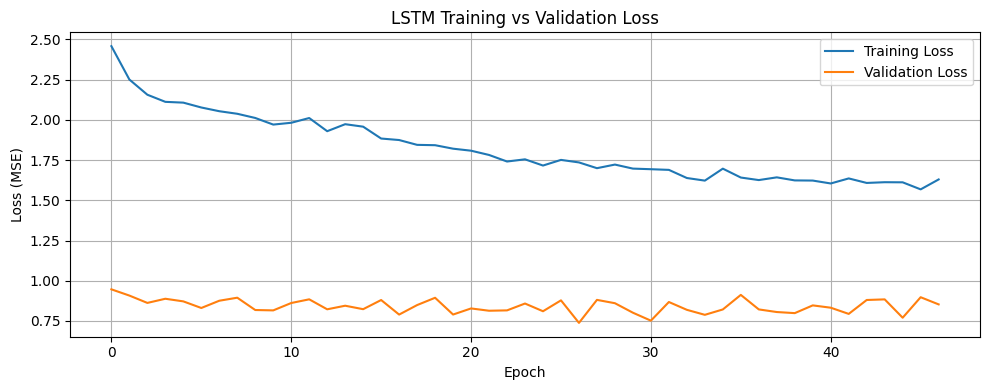

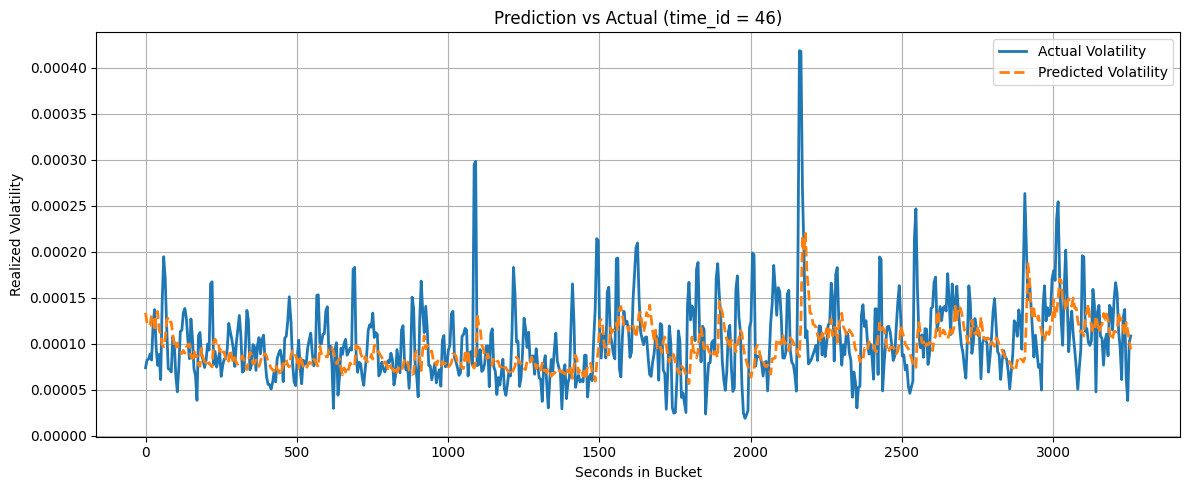

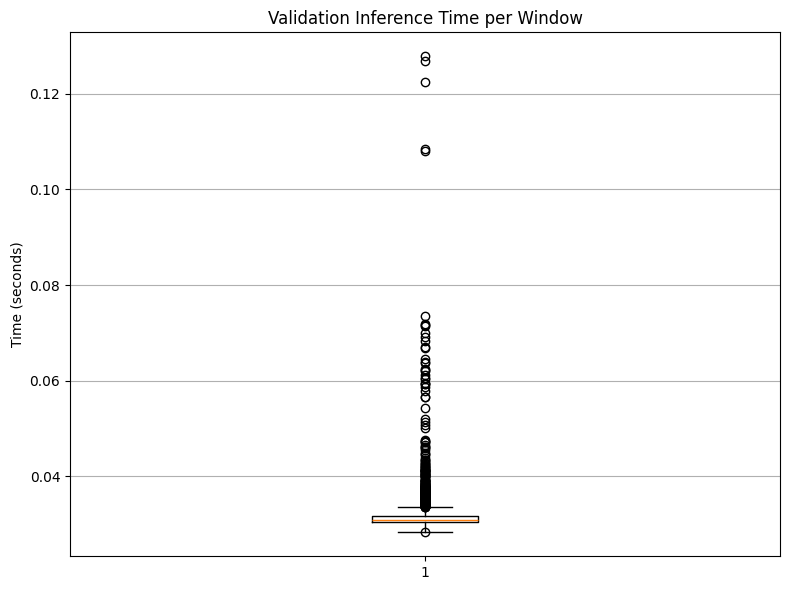

,time_id,start_time,y_true,y_pred,inference_time
0,46,0.0,0.000074,0.000133,0.108399
1,46,5.0,0.000082,0.000122,0.034024
2,46,10.0,0.000083,0.000120,0.034179
3,46,15.0,0.000089,0.000120,0.034000
4,46,20.0,0.000082,0.000131,0.033737
5,46,25.0,0.000121,0.000128,0.030836
6,46,30.0,0.000137,0.000114,0.030851
7,46,35.0,0.000096,0.000132,0.030173
8,46,40.0,0.000076,0.000135,0.029807
9,46,45.0,0.000088,0.000115,0.030413


In [5]:
util.plot_training_loss(history_lstm_weighted_mse)

util.plot_prediction_vs_actual(
    val_df_lstm_weighted_mse,
    time_id=val_df_lstm_weighted_mse['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(val_df_lstm_weighted_mse)

display(val_df_lstm_weighted_mse.head(10))

val_df_lstm_weighted_mse.to_csv('out/val_df/weighted_mse.csv', index=False)

In [6]:
K.clear_session()
gc.collect()

0

### LSTM with Two-Staged Training (Weighted MSE + Quantile)

In [7]:
importlib.reload(lstm)

feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]

model_lstm_2_eval, history_lstm_2_eval, val_df_lstm_2_eval = lstm.baseline_two_stage_eval(
    snapshot_df=subset_snapshot_df,
    basic_features=feature_cols,
    epochs_stage1  = 60,
    epochs_stage2 = 40,
    batch_size = 32,
    learning_rate=5e-5,
    es_patience=20,
    lr_patience=5,
    model_name='staged',
)

Epoch 1/60
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.7422 - mae: 0.6306 - rmse: 0.8655

814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 2.7417 - mae: 0.6305 - rmse: 0.8654 - val_loss: 0.9526 - val_mae: 0.4152 - val_rmse: 0.5797 - learning_rate: 5.0000e-05
Epoch 2/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.1084 - mae: 0.5743 - rmse: 0.8005

814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 2.1086 - mae: 0.5743 - rmse: 0.8005 - val_loss: 0.9415 - val_mae: 0.4149 - val_rmse: 0.5685 - learning_rate: 5.0000e-05
Epoch 3/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.1191 - mae: 0.5696 - rmse: 0.7988

814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 2.1193 - mae: 0.5696 - rmse: 0.7988 - val_loss: 0.8987 - val_mae: 0.4093 - val_rmse: 0.5592 - learning_rate: 5.0000e-05
Epoch 4/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 2.4876 - mae: 0.5636 - rmse: 0.8049 - val_loss: 0.9364 - val_mae: 0.4188 - val_rmse: 0.5705 - learning_rate: 5.0000e-05
Epoch 5/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 2.2048 - mae: 0.5636 - rmse: 0.7955 - val_loss: 0.9324 - val_mae: 0.4264 - val_rmse: 0.5707 - learning_rate: 5.0000e-05
Epoch 6/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 2.1805 - mae: 0.5599 - rmse: 0.7896 - val_loss: 0.9091 - val_mae: 0.4300 - val_rmse: 0.5722 - learning_rate: 5.0000e-05
Epoch 7/60
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.0520 - mae: 0.5610 - rmse: 0.7845

814/814 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 2.0521 - mae: 0.5610 - rmse: 0.7845 - val_loss: 0.8946 - val_mae: 0.4178 - val_rmse: 0.5595 - learning_rate: 5.0000e-05
Epoch 8/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 2.1527 - mae: 0.5565 - rmse: 0.7846 - val_loss: 0.9372 - val_mae: 0.4101 - val_rmse: 0.5591 - learning_rate: 5.0000e-05
Epoch 9/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.0628 - mae: 0.5638 - rmse: 0.7850

814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 2.0627 - mae: 0.5638 - rmse: 0.7850 - val_loss: 0.8919 - val_mae: 0.4136 - val_rmse: 0.5603 - learning_rate: 5.0000e-05
Epoch 10/60
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.7239 - mae: 0.5615 - rmse: 0.8101

814/814 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 2.7225 - mae: 0.5615 - rmse: 0.8100 - val_loss: 0.8444 - val_mae: 0.3888 - val_rmse: 0.5452 - learning_rate: 5.0000e-05
Epoch 11/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 2.1257 - mae: 0.5526 - rmse: 0.7767 - val_loss: 0.8660 - val_mae: 0.3991 - val_rmse: 0.5505 - learning_rate: 5.0000e-05
Epoch 12/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 2.0626 - mae: 0.5534 - rmse: 0.7772 - val_loss: 0.8725 - val_mae: 0.4023 - val_rmse: 0.5544 - learning_rate: 5.0000e-05
Epoch 13/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.1101 - mae: 0.5461 - rmse: 0.7719

814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 2.1100 - mae: 0.5461 - rmse: 0.7719 - val_loss: 0.8144 - val_mae: 0.3811 - val_rmse: 0.5335 - learning_rate: 5.0000e-05
Epoch 14/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 2.0797 - mae: 0.5441 - rmse: 0.7665 - val_loss: 0.8273 - val_mae: 0.3892 - val_rmse: 0.5373 - learning_rate: 5.0000e-05
Epoch 15/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 2.1744 - mae: 0.5468 - rmse: 0.7738 - val_loss: 0.8794 - val_mae: 0.3944 - val_rmse: 0.5477 - learning_rate: 5.0000e-05
Epoch 16/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 1.8463 - mae: 0.5468 - rmse: 0.7581 - val_loss: 0.8630 - val_mae: 0.4013 - val_rmse: 0.5500 - learning_rate: 5.0000e-05
Epoch 17/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 2.2935 - mae: 0.5507 - rmse: 0.7857 - val_loss: 0.8501 - val_mae: 0.3810 - val_rmse: 0.5386 - learning_rate: 5.0000e-05
Epoch 18/60
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.8742 - mae: 0.5390 - rmse: 0.7517

814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 1.8745 - mae: 0.5390 - rmse: 0.7517 - val_loss: 0.8058 - val_mae: 0.3855 - val_rmse: 0.5349 - learning_rate: 5.0000e-05
Epoch 19/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 1.7941 - mae: 0.5365 - rmse: 0.7475 - val_loss: 0.8890 - val_mae: 0.4046 - val_rmse: 0.5526 - learning_rate: 5.0000e-05
Epoch 20/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 1.7345 - mae: 0.5352 - rmse: 0.7399 - val_loss: 0.8472 - val_mae: 0.3961 - val_rmse: 0.5457 - learning_rate: 5.0000e-05
Epoch 21/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 2.0748 - mae: 0.5451 - rmse: 0.7689 - val_loss: 0.8295 - val_mae: 0.4068 - val_rmse: 0.5459 - learning_rate: 5.0000e-05
Epoch 22/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 1.9835 - mae: 0.5424 - rmse: 0.7625 - val_loss: 0.8442 - val_mae: 0.3822 - val_rmse: 0.5415 - learning_rate: 5.0000e-05
Epoch 23/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 1.9916 - mae: 0.5494 - rmse: 0.774

814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 2.0799 - mae: 0.5383 - rmse: 0.7620 - val_loss: 0.7908 - val_mae: 0.3903 - val_rmse: 0.5346 - learning_rate: 1.2500e-05
Epoch 31/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 1.8402 - mae: 0.5400 - rmse: 0.7571 - val_loss: 0.8438 - val_mae: 0.4018 - val_rmse: 0.5440 - learning_rate: 1.2500e-05
Epoch 32/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 1.9110 - mae: 0.5369 - rmse: 0.7516 - val_loss: 0.8963 - val_mae: 0.3889 - val_rmse: 0.5466 - learning_rate: 1.2500e-05
Epoch 33/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 1.8071 - mae: 0.5342 - rmse: 0.7483 - val_loss: 0.8550 - val_mae: 0.3985 - val_rmse: 0.5492 - learning_rate: 1.2500e-05
Epoch 34/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.8369 - mae: 0.5425 - rmse: 0.7595

814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 1.8369 - mae: 0.5425 - rmse: 0.7595 - val_loss: 0.7368 - val_mae: 0.3937 - val_rmse: 0.5267 - learning_rate: 1.2500e-05
Epoch 35/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 1.7538 - mae: 0.5311 - rmse: 0.7390 - val_loss: 0.9206 - val_mae: 0.3891 - val_rmse: 0.5523 - learning_rate: 1.2500e-05
Epoch 36/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 1.8556 - mae: 0.5393 - rmse: 0.7543 - val_loss: 0.8097 - val_mae: 0.3923 - val_rmse: 0.5363 - learning_rate: 1.2500e-05
Epoch 37/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 1.7568 - mae: 0.5329 - rmse: 0.7420 - val_loss: 0.8137 - val_mae: 0.4058 - val_rmse: 0.5464 - learning_rate: 1.2500e-05
Epoch 38/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - loss: 1.7270 - mae: 0.5347 - rmse: 0.7424 - val_loss: 0.8461 - val_mae: 0.3884 - val_rmse: 0.5379 - learning_rate: 1.2500e-05
Epoch 39/60
814/814 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - loss: 1.7692 - mae: 0.5419 - rmse: 0.751

814/814 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 0.2391 - mae: 0.5548 - rmse: 0.7518 - val_loss: 0.1837 - val_mae: 0.4765 - val_rmse: 0.6104 - learning_rate: 5.0000e-06
Epoch 2/40
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2358 - mae: 0.5604 - rmse: 0.7495

814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.2358 - mae: 0.5604 - rmse: 0.7495 - val_loss: 0.1788 - val_mae: 0.4651 - val_rmse: 0.5862 - learning_rate: 5.0000e-06
Epoch 3/40
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 0.2378 - mae: 0.5626 - rmse: 0.7497 - val_loss: 0.1807 - val_mae: 0.4615 - val_rmse: 0.5949 - learning_rate: 5.0000e-06
Epoch 4/40
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.2334 - mae: 0.5576 - rmse: 0.7440 - val_loss: 0.1811 - val_mae: 0.4656 - val_rmse: 0.5872 - learning_rate: 5.0000e-06
Epoch 5/40
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2344 - mae: 0.5590 - rmse: 0.7524

814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.2344 - mae: 0.5590 - rmse: 0.7524 - val_loss: 0.1738 - val_mae: 0.4433 - val_rmse: 0.5755 - learning_rate: 5.0000e-06
Epoch 6/40
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.2357 - mae: 0.5624 - rmse: 0.7593 - val_loss: 0.1797 - val_mae: 0.4594 - val_rmse: 0.5851 - learning_rate: 5.0000e-06
Epoch 7/40
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.2362 - mae: 0.5606 - rmse: 0.7516 - val_loss: 0.1806 - val_mae: 0.4706 - val_rmse: 0.6020 - learning_rate: 5.0000e-06
Epoch 8/40
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.2387 - mae: 0.5669 - rmse: 0.7657 - val_loss: 0.1762 - val_mae: 0.4403 - val_rmse: 0.5630 - learning_rate: 5.0000e-06
Epoch 9/40
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.2383 - mae: 0.5596 - rmse: 0.7624 - val_loss: 0.1795 - val_mae: 0.4580 - val_rmse: 0.5957 - learning_rate: 2.5000e-06
Epoch 10/40
814/814 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 0.2347 - mae: 0.5570 - rmse: 0.7486 - 

Final RMSE:  0.00004342
Final QLIKE:0.3834
Dir Acc:    0.3869


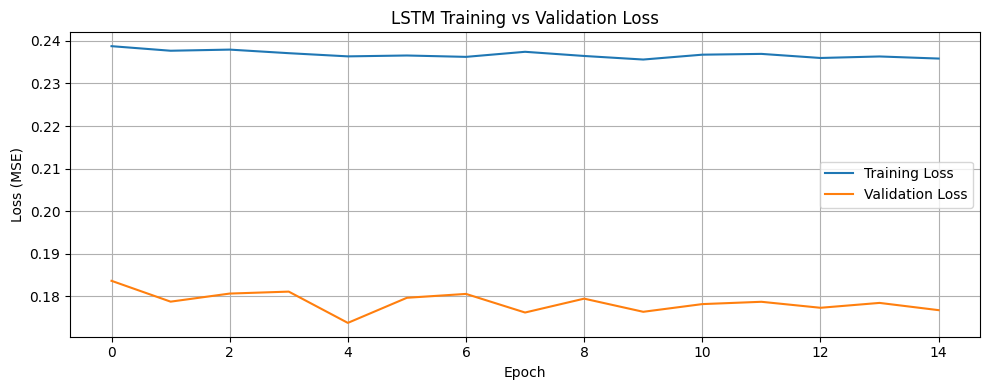

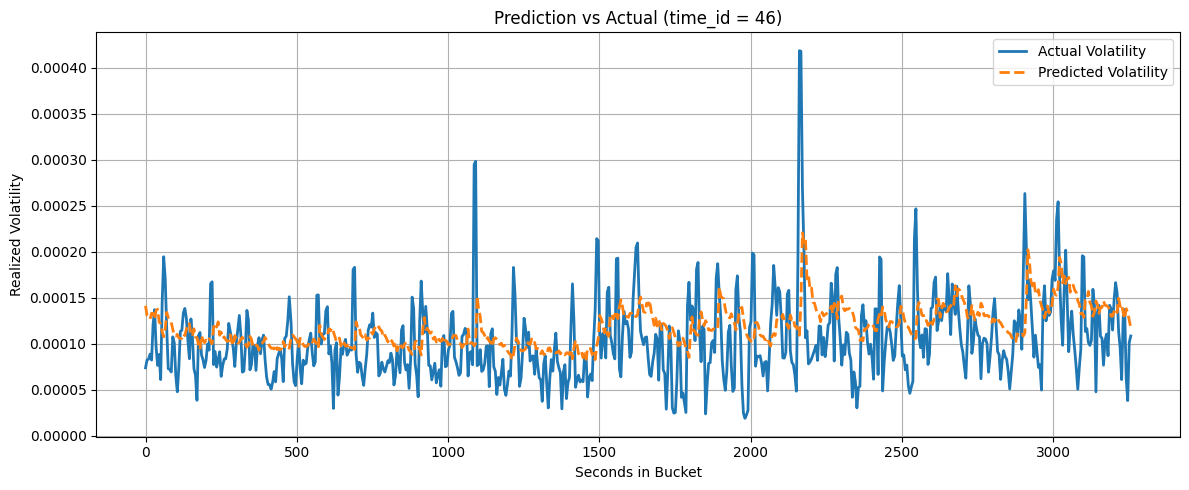

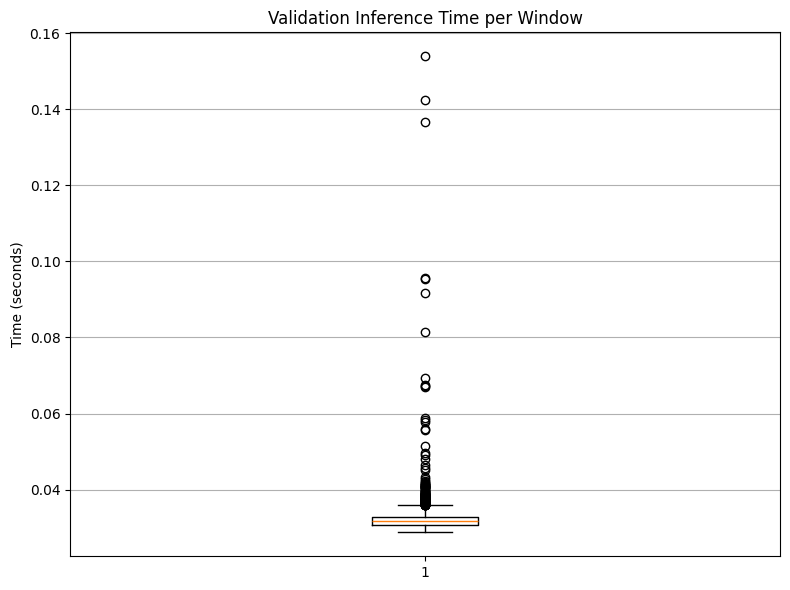

,time_id,start_time,y_true,y_pred,inference_time
0,46,0.0,0.000074,0.000141,0.095386
1,46,5.0,0.000082,0.000130,0.031112
2,46,10.0,0.000083,0.000128,0.033117
3,46,15.0,0.000089,0.000127,0.032440
4,46,20.0,0.000082,0.000133,0.030842
5,46,25.0,0.000121,0.000133,0.030382
6,46,30.0,0.000137,0.000126,0.032001
7,46,35.0,0.000096,0.000136,0.030909
8,46,40.0,0.000076,0.000137,0.031044
9,46,45.0,0.000088,0.000124,0.030822


In [17]:
util.plot_training_loss(history_lstm_2_eval)

util.plot_prediction_vs_actual(
    val_df_lstm_2_eval,
    time_id=val_df_lstm_2_eval['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)


util.plot_inference_time_boxplot(val_df_lstm_2_eval)

display(val_df_lstm_2_eval.head(10))

val_df_lstm_2_eval.to_csv('out/val_df/staged.csv', index=False)

In [9]:
K.clear_session()
gc.collect()

0

### Mixture-of-Expert LSTM with Spike Classification

In [7]:
importlib.reload(lstm)

feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]

model_lstm_moe, history_lstm_moe, val_df_lstm_moe = lstm.baseline_moe_spike(
    snapshot_df=subset_snapshot_df,
    basic_features=feature_cols,
    epochs=100,
    batch_size=32,
    learning_rate=1e-4,
    es_patience=20,
    lr_patience=5,
    model_name='moe',
)

Dynamic oversample_factor = 4.0
Epoch 1/100


2025-05-22 01:55:33.375676: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-22 01:55:33.375708: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-22 01:55:33.375718: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-22 01:55:33.375734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-22 01:55:33.375743: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-22 01:55:33.900221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 9.3370 - spike_accuracy: 0.4199 - spike_loss: 0.0122 - vol_loss: 9.3309 - vol_rmse: 1.4273

814/814 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - loss: 9.3366 - spike_accuracy: 0.4199 - spike_loss: 0.0122 - vol_loss: 9.3305 - vol_rmse: 1.4273 - val_loss: 1.3127 - val_spike_accuracy: 0.2525 - val_spike_loss: 0.0144 - val_vol_loss: 1.3053 - val_vol_rmse: 0.6868 - learning_rate: 9.9877e-06
Epoch 2/100
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.7777 - spike_accuracy: 0.4217 - spike_loss: 0.0166 - vol_loss: 4.7660 - vol_rmse: 1.1191

814/814 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 4.7759 - spike_accuracy: 0.4217 - spike_loss: 0.0166 - vol_loss: 4.7642 - vol_rmse: 1.1190 - val_loss: 1.1894 - val_spike_accuracy: 0.2002 - val_spike_loss: 0.0171 - val_vol_loss: 1.1809 - val_vol_rmse: 0.6708 - learning_rate: 1.9988e-05
Epoch 3/100
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.8490 - spike_accuracy: 0.4423 - spike_loss: 0.0205 - vol_loss: 3.8353 - vol_rmse: 1.0879

814/814 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - loss: 3.8488 - spike_accuracy: 0.4422 - spike_loss: 0.0205 - vol_loss: 3.8351 - vol_rmse: 1.0879 - val_loss: 1.1506 - val_spike_accuracy: 0.2148 - val_spike_loss: 0.0162 - val_vol_loss: 1.1425 - val_vol_rmse: 0.6555 - learning_rate: 2.9988e-05
Epoch 4/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - loss: 3.5158 - spike_accuracy: 0.4462 - spike_loss: 0.0193 - vol_loss: 3.5178 - vol_rmse: 1.0607 - val_loss: 1.1558 - val_spike_accuracy: 0.2494 - val_spike_loss: 0.0150 - val_vol_loss: 1.1475 - val_vol_rmse: 0.6593 - learning_rate: 3.9988e-05
Epoch 5/100
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.8006 - spike_accuracy: 0.4544 - spike_loss: 0.0178 - vol_loss: 3.7906 - vol_rmse: 1.0749

814/814 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 3.8007 - spike_accuracy: 0.4544 - spike_loss: 0.0178 - vol_loss: 3.7908 - vol_rmse: 1.0749 - val_loss: 1.0747 - val_spike_accuracy: 0.2505 - val_spike_loss: 0.0145 - val_vol_loss: 1.0664 - val_vol_rmse: 0.6349 - learning_rate: 4.9988e-05
Epoch 6/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 3.9901 - spike_accuracy: 0.4683 - spike_loss: 0.0162 - vol_loss: 3.9812 - vol_rmse: 1.0645 - val_loss: 1.0846 - val_spike_accuracy: 0.2709 - val_spike_loss: 0.0138 - val_vol_loss: 1.0765 - val_vol_rmse: 0.6400 - learning_rate: 5.9988e-05
Epoch 7/100
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.7384 - spike_accuracy: 0.4789 - spike_loss: 0.0151 - vol_loss: 3.7306 - vol_rmse: 1.0550

814/814 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - loss: 3.7381 - spike_accuracy: 0.4789 - spike_loss: 0.0151 - vol_loss: 3.7303 - vol_rmse: 1.0550 - val_loss: 1.0189 - val_spike_accuracy: 0.2488 - val_spike_loss: 0.0137 - val_vol_loss: 1.0111 - val_vol_rmse: 0.6137 - learning_rate: 6.9988e-05
Epoch 8/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - loss: 3.5893 - spike_accuracy: 0.4970 - spike_loss: 0.0140 - vol_loss: 3.5823 - vol_rmse: 1.0522 - val_loss: 1.0221 - val_spike_accuracy: 0.4298 - val_spike_loss: 0.0119 - val_vol_loss: 1.0152 - val_vol_rmse: 0.6202 - learning_rate: 7.9988e-05
Epoch 9/100
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.1986 - spike_accuracy: 0.5645 - spike_loss: 0.0121 - vol_loss: 4.1828 - vol_rmse: 1.0749

814/814 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 4.1983 - spike_accuracy: 0.5645 - spike_loss: 0.0121 - vol_loss: 4.1825 - vol_rmse: 1.0749 - val_loss: 1.0084 - val_spike_accuracy: 0.5203 - val_spike_loss: 0.0111 - val_vol_loss: 1.0018 - val_vol_rmse: 0.6161 - learning_rate: 8.9988e-05
Epoch 10/100
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.2719 - spike_accuracy: 0.6278 - spike_loss: 0.0113 - vol_loss: 4.2614 - vol_rmse: 1.0886

814/814 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 4.2704 - spike_accuracy: 0.6278 - spike_loss: 0.0113 - vol_loss: 4.2599 - vol_rmse: 1.0885 - val_loss: 0.9896 - val_spike_accuracy: 0.5995 - val_spike_loss: 0.0105 - val_vol_loss: 0.9832 - val_vol_rmse: 0.6165 - learning_rate: 9.9988e-05
Epoch 11/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 3.5318 - spike_accuracy: 0.6866 - spike_loss: 0.0106 - vol_loss: 3.5231 - vol_rmse: 1.0472 - val_loss: 0.9956 - val_spike_accuracy: 0.7727 - val_spike_loss: 0.0095 - val_vol_loss: 0.9897 - val_vol_rmse: 0.6198 - learning_rate: 9.9988e-05
Epoch 12/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.4708 - spike_accuracy: 0.7227 - spike_loss: 0.0104 - vol_loss: 3.4645 - vol_rmse: 1.0443

814/814 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 3.4706 - spike_accuracy: 0.7227 - spike_loss: 0.0104 - vol_loss: 3.4642 - vol_rmse: 1.0443 - val_loss: 0.9507 - val_spike_accuracy: 0.8655 - val_spike_loss: 0.0086 - val_vol_loss: 0.9454 - val_vol_rmse: 0.5960 - learning_rate: 9.9988e-05
Epoch 13/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 3.6138 - spike_accuracy: 0.7498 - spike_loss: 0.0098 - vol_loss: 3.6081 - vol_rmse: 1.0420 - val_loss: 0.9538 - val_spike_accuracy: 0.8913 - val_spike_loss: 0.0080 - val_vol_loss: 0.9487 - val_vol_rmse: 0.5951 - learning_rate: 9.9988e-05
Epoch 14/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 3.1442 - spike_accuracy: 0.7586 - spike_loss: 0.0094 - vol_loss: 3.1389 - vol_rmse: 1.0115 - val_loss: 0.9698 - val_spike_accuracy: 0.9111 - val_spike_loss: 0.0074 - val_vol_loss: 0.9652 - val_vol_rmse: 0.5964 - learning_rate: 9.9988e-05
Epoch 15/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 3.0414 - spike_accuracy: 0.7528 - spike_los

814/814 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 2.7021 - spike_accuracy: 0.7464 - spike_loss: 0.0089 - vol_loss: 2.6967 - vol_rmse: 0.9689 - val_loss: 0.9332 - val_spike_accuracy: 0.9225 - val_spike_loss: 0.0062 - val_vol_loss: 0.9291 - val_vol_rmse: 0.5887 - learning_rate: 4.9994e-05
Epoch 21/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 2.4545 - spike_accuracy: 0.7542 - spike_loss: 0.0088 - vol_loss: 2.4498 - vol_rmse: 0.9439 - val_loss: 0.9505 - val_spike_accuracy: 0.9237 - val_spike_loss: 0.0059 - val_vol_loss: 0.9465 - val_vol_rmse: 0.5948 - learning_rate: 4.9994e-05
Epoch 22/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 2.4491 - spike_accuracy: 0.7480 - spike_loss: 0.0087 - vol_loss: 2.4450 - vol_rmse: 0.9440 - val_loss: 1.0300 - val_spike_accuracy: 0.9180 - val_spike_loss: 0.0060 - val_vol_loss: 1.0258 - val_vol_rmse: 0.6369 - learning_rate: 4.9994e-05
Epoch 23/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 2.3293 - spike_accuracy: 0.7535 - spike_los

Best spike threshold by F1: 0.520
Calibrated RMSE: 0.00004566
Calibrated QLIKE: 0.4038
Spike Acc: 0.956081081081081
Spike Recall: 0.3958333333333333


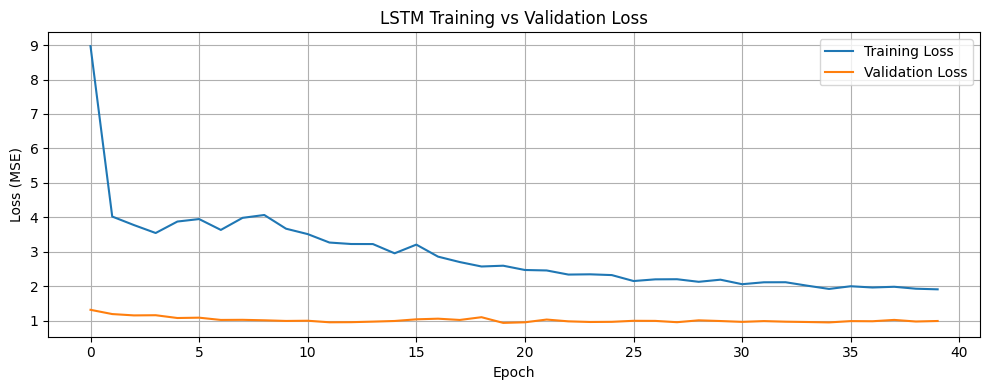

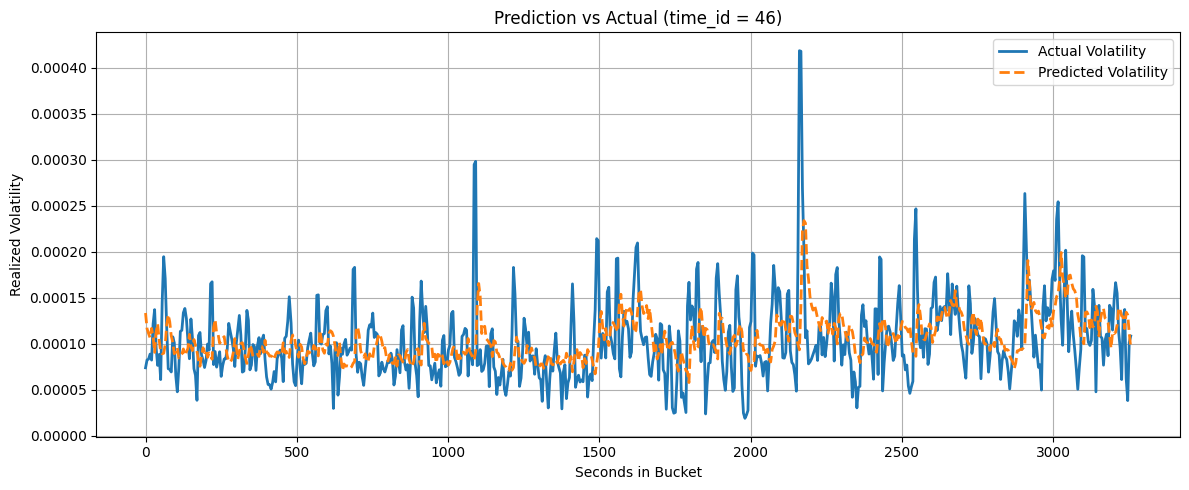

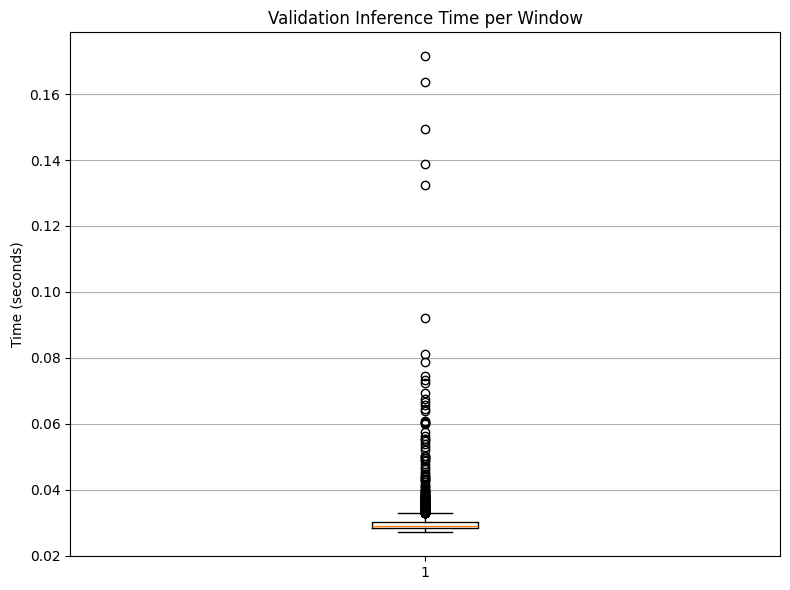

,time_id,start_time,y_true,y_pred,spike_prob,expert_normal,expert_spike,inference_time,y_pred_calibrated
0,46,0.0,0.000074,0.000133,0.451184,0.000140,0.000125,0.149286,0.000140
1,46,5.0,0.000082,0.000116,0.441656,0.000121,0.000110,0.030651,0.000121
2,46,10.0,0.000083,0.000111,0.432864,0.000106,0.000118,0.028769,0.000106
3,46,15.0,0.000089,0.000106,0.409734,0.000106,0.000107,0.029208,0.000106
4,46,20.0,0.000082,0.000117,0.401565,0.000125,0.000104,0.028683,0.000125
5,46,25.0,0.000121,0.000107,0.432814,0.000106,0.000109,0.028040,0.000106
6,46,30.0,0.000137,0.000090,0.439634,0.000090,0.000091,0.028741,0.000090
7,46,35.0,0.000096,0.000112,0.408674,0.000118,0.000103,0.028777,0.000118
8,46,40.0,0.000076,0.000122,0.407701,0.000129,0.000111,0.028340,0.000129
9,46,45.0,0.000088,0.000104,0.454837,0.000111,0.000095,0.028415,0.000111


In [8]:
util.plot_training_loss(history_lstm_moe)

util.plot_prediction_vs_actual(
    val_df_lstm_moe,
    time_id=val_df_lstm_moe['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(val_df_lstm_moe)

display(val_df_lstm_moe.head(10))

val_df_lstm_moe.to_csv('out/val_df/moe.csv', index=False)


In [ ]:
K.clear_session()
gc.collect()

0

### MoE LSTM with Two-Staged Training

In [9]:
importlib.reload(lstm)

feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]

model_lstm_moe_stage, history_lstm_moe_stage_1, history_lstm_moe_stage_2, val_df_lstm_moe_staged = lstm.moe_spike_staged(
    snapshot_df=subset_snapshot_df,
    basic_features=feature_cols,
    epochs=100,
    batch_size=32,
    learning_rate=1e-3,
    es_patience=20,
    lr_patience=5,
    model_name='moe_staged',
)

Epoch 1/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 9.6861 - spike_accuracy: 0.5497 - spike_loss: 0.0106 - vol_loss: 9.6861 - vol_rmse: 1.4784

814/814 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 9.6845 - spike_accuracy: 0.5497 - spike_loss: 0.0106 - vol_loss: 9.6845 - vol_rmse: 1.4783 - val_loss: 1.3685 - val_spike_accuracy: 0.6608 - val_spike_loss: 0.0098 - val_vol_loss: 1.3683 - val_vol_rmse: 0.7332 - learning_rate: 1.9975e-05
Epoch 2/50
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.0541 - spike_accuracy: 0.5121 - spike_loss: 0.0110 - vol_loss: 4.0517 - vol_rmse: 1.1163

814/814 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 4.0541 - spike_accuracy: 0.5121 - spike_loss: 0.0110 - vol_loss: 4.0517 - vol_rmse: 1.1163 - val_loss: 1.2763 - val_spike_accuracy: 0.6962 - val_spike_loss: 0.0095 - val_vol_loss: 1.2763 - val_vol_rmse: 0.6997 - learning_rate: 3.9975e-05
Epoch 3/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.6161 - spike_accuracy: 0.5117 - spike_loss: 0.0112 - vol_loss: 3.6132 - vol_rmse: 1.0640

814/814 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 3.6161 - spike_accuracy: 0.5117 - spike_loss: 0.0112 - vol_loss: 3.6132 - vol_rmse: 1.0640 - val_loss: 1.1655 - val_spike_accuracy: 0.7771 - val_spike_loss: 0.0090 - val_vol_loss: 1.1655 - val_vol_rmse: 0.6627 - learning_rate: 5.9975e-05
Epoch 4/50
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.6978 - spike_accuracy: 0.5503 - spike_loss: 0.0114 - vol_loss: 3.6952 - vol_rmse: 1.0605

814/814 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - loss: 3.6978 - spike_accuracy: 0.5504 - spike_loss: 0.0114 - vol_loss: 3.6951 - vol_rmse: 1.0605 - val_loss: 1.0951 - val_spike_accuracy: 0.9016 - val_spike_loss: 0.0081 - val_vol_loss: 1.0940 - val_vol_rmse: 0.6479 - learning_rate: 7.9975e-05
Epoch 5/50
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.6926 - spike_accuracy: 0.5953 - spike_loss: 0.0116 - vol_loss: 3.6918 - vol_rmse: 1.0437

814/814 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 3.6928 - spike_accuracy: 0.5953 - spike_loss: 0.0116 - vol_loss: 3.6921 - vol_rmse: 1.0437 - val_loss: 1.0138 - val_spike_accuracy: 0.8879 - val_spike_loss: 0.0082 - val_vol_loss: 1.0126 - val_vol_rmse: 0.6259 - learning_rate: 9.9975e-05
Epoch 6/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.9213 - spike_accuracy: 0.6107 - spike_loss: 0.0114 - vol_loss: 3.9207 - vol_rmse: 1.0596

814/814 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - loss: 3.9214 - spike_accuracy: 0.6107 - spike_loss: 0.0114 - vol_loss: 3.9208 - vol_rmse: 1.0596 - val_loss: 0.9785 - val_spike_accuracy: 0.8962 - val_spike_loss: 0.0080 - val_vol_loss: 0.9775 - val_vol_rmse: 0.5990 - learning_rate: 1.1998e-04
Epoch 7/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 3.9104 - spike_accuracy: 0.6223 - spike_loss: 0.0115 - vol_loss: 3.9101 - vol_rmse: 1.0589 - val_loss: 1.0440 - val_spike_accuracy: 0.8702 - val_spike_loss: 0.0079 - val_vol_loss: 1.0431 - val_vol_rmse: 0.6245 - learning_rate: 1.3998e-04
Epoch 8/50
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.7838 - spike_accuracy: 0.6468 - spike_loss: 0.0111 - vol_loss: 3.7838 - vol_rmse: 1.0637

814/814 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 3.7827 - spike_accuracy: 0.6468 - spike_loss: 0.0111 - vol_loss: 3.7827 - vol_rmse: 1.0636 - val_loss: 0.9738 - val_spike_accuracy: 0.9455 - val_spike_loss: 0.0067 - val_vol_loss: 0.9728 - val_vol_rmse: 0.6028 - learning_rate: 1.5998e-04
Epoch 9/50
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.1678 - spike_accuracy: 0.6431 - spike_loss: 0.0124 - vol_loss: 3.1685 - vol_rmse: 1.0167

814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - loss: 3.1681 - spike_accuracy: 0.6431 - spike_loss: 0.0124 - vol_loss: 3.1688 - vol_rmse: 1.0167 - val_loss: 0.9314 - val_spike_accuracy: 0.9123 - val_spike_loss: 0.0073 - val_vol_loss: 0.9304 - val_vol_rmse: 0.5843 - learning_rate: 1.7998e-04
Epoch 10/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - loss: 3.4143 - spike_accuracy: 0.6636 - spike_loss: 0.0117 - vol_loss: 3.4098 - vol_rmse: 1.0418 - val_loss: 0.9533 - val_spike_accuracy: 0.9137 - val_spike_loss: 0.0072 - val_vol_loss: 0.9521 - val_vol_rmse: 0.6035 - learning_rate: 1.9998e-04
Epoch 11/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 3.9158 - spike_accuracy: 0.6464 - spike_loss: 0.0131 - vol_loss: 3.9148 - vol_rmse: 1.0595 - val_loss: 0.9691 - val_spike_accuracy: 0.9243 - val_spike_loss: 0.0062 - val_vol_loss: 0.9682 - val_vol_rmse: 0.5949 - learning_rate: 2.1998e-04
Epoch 12/50
813/814 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.2288 - spike_accuracy: 0.6436 - spike_loss: 0

814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 3.2292 - spike_accuracy: 0.6436 - spike_loss: 0.0128 - vol_loss: 3.2281 - vol_rmse: 1.0012 - val_loss: 0.9132 - val_spike_accuracy: 0.9340 - val_spike_loss: 0.0059 - val_vol_loss: 0.9123 - val_vol_rmse: 0.5713 - learning_rate: 2.3998e-04
Epoch 13/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 2.9725 - spike_accuracy: 0.6544 - spike_loss: 0.0127 - vol_loss: 2.9715 - vol_rmse: 1.0016 - val_loss: 2.0967 - val_spike_accuracy: 0.9165 - val_spike_loss: 0.0056 - val_vol_loss: 2.0930 - val_vol_rmse: 0.9597 - learning_rate: 2.5998e-04
Epoch 14/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 2.8681 - spike_accuracy: 0.6780 - spike_loss: 0.0125 - vol_loss: 2.8688 - vol_rmse: 1.0015 - val_loss: 0.9449 - val_spike_accuracy: 0.9664 - val_spike_loss: 0.0042 - val_vol_loss: 0.9440 - val_vol_rmse: 0.5964 - learning_rate: 2.7998e-04
Epoch 15/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 2.8759 - spike_accuracy: 0.6907 - spike_loss: 

814/814 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - loss: 2.9506 - spike_accuracy: 0.6646 - spike_loss: 0.0121 - vol_loss: 2.9456 - vol_rmse: 0.9848 - val_loss: 0.9746 - val_spike_accuracy: 0.9260 - val_spike_loss: 0.0060 - val_vol_loss: 0.9707 - val_vol_rmse: 0.6036 - learning_rate: 1.9975e-05
Epoch 2/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 2.8129 - spike_accuracy: 0.6488 - spike_loss: 0.0129 - vol_loss: 2.8047 - vol_rmse: 0.9802 - val_loss: 1.0225 - val_spike_accuracy: 0.9209 - val_spike_loss: 0.0061 - val_vol_loss: 1.0184 - val_vol_rmse: 0.6284 - learning_rate: 3.9975e-05
Epoch 3/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 2.9996 - spike_accuracy: 0.6606 - spike_loss: 0.0127 - vol_loss: 2.9938 - vol_rmse: 0.9934 - val_loss: 0.9763 - val_spike_accuracy: 0.9208 - val_spike_loss: 0.0063 - val_vol_loss: 0.9723 - val_vol_rmse: 0.6009 - learning_rate: 5.9975e-05
Epoch 4/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.7762 - spike_accuracy: 0.6609 - spike_loss: 0.01

814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - loss: 2.7762 - spike_accuracy: 0.6609 - spike_loss: 0.0128 - vol_loss: 2.7699 - vol_rmse: 0.9773 - val_loss: 0.9597 - val_spike_accuracy: 0.9372 - val_spike_loss: 0.0057 - val_vol_loss: 0.9558 - val_vol_rmse: 0.6029 - learning_rate: 7.9975e-05
Epoch 5/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 2.7764 - spike_accuracy: 0.6750 - spike_loss: 0.0120 - vol_loss: 2.7701 - vol_rmse: 0.9841 - val_loss: 0.9628 - val_spike_accuracy: 0.9438 - val_spike_loss: 0.0055 - val_vol_loss: 0.9591 - val_vol_rmse: 0.5963 - learning_rate: 9.9975e-05
Epoch 6/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 2.6152 - spike_accuracy: 0.6762 - spike_loss: 0.0120 - vol_loss: 2.6092 - vol_rmse: 0.9678 - val_loss: 0.9643 - val_spike_accuracy: 0.9573 - val_spike_loss: 0.0050 - val_vol_loss: 0.9608 - val_vol_rmse: 0.6056 - learning_rate: 1.1998e-04
Epoch 7/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 2.6782 - spike_accuracy: 0.6984 - spike_loss: 0.0

814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 2.5040 - spike_accuracy: 0.7153 - spike_loss: 0.0108 - vol_loss: 2.4977 - vol_rmse: 0.9591 - val_loss: 0.9551 - val_spike_accuracy: 0.9525 - val_spike_loss: 0.0045 - val_vol_loss: 0.9518 - val_vol_rmse: 0.6039 - learning_rate: 1.7998e-04
Epoch 10/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 2.6027 - spike_accuracy: 0.7209 - spike_loss: 0.0102 - vol_loss: 2.5960 - vol_rmse: 0.9632 - val_loss: 0.9891 - val_spike_accuracy: 0.9678 - val_spike_loss: 0.0041 - val_vol_loss: 0.9860 - val_vol_rmse: 0.6162 - learning_rate: 1.9998e-04
Epoch 11/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 2.3806 - spike_accuracy: 0.7244 - spike_loss: 0.0100 - vol_loss: 2.3756 - vol_rmse: 0.9422 - val_loss: 1.1228 - val_spike_accuracy: 0.9667 - val_spike_loss: 0.0039 - val_vol_loss: 1.1196 - val_vol_rmse: 0.6751 - learning_rate: 2.1998e-04
Epoch 12/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 2.3836 - spike_accuracy: 0.7396 - spike_loss: 

814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 2.0706 - spike_accuracy: 0.7532 - spike_loss: 0.0085 - vol_loss: 2.0650 - vol_rmse: 0.9073 - val_loss: 0.9171 - val_spike_accuracy: 0.9556 - val_spike_loss: 0.0036 - val_vol_loss: 0.9140 - val_vol_rmse: 0.6124 - learning_rate: 3.1998e-04
Epoch 17/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.0473 - spike_accuracy: 0.7367 - spike_loss: 0.0091 - vol_loss: 2.0435 - vol_rmse: 0.8980

814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 2.0472 - spike_accuracy: 0.7367 - spike_loss: 0.0091 - vol_loss: 2.0434 - vol_rmse: 0.8980 - val_loss: 0.9105 - val_spike_accuracy: 0.9650 - val_spike_loss: 0.0032 - val_vol_loss: 0.9079 - val_vol_rmse: 0.6060 - learning_rate: 3.3998e-04
Epoch 18/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 1.8810 - spike_accuracy: 0.7440 - spike_loss: 0.0089 - vol_loss: 1.8756 - vol_rmse: 0.8677 - val_loss: 0.9611 - val_spike_accuracy: 0.9756 - val_spike_loss: 0.0021 - val_vol_loss: 0.9588 - val_vol_rmse: 0.6116 - learning_rate: 3.5998e-04
Epoch 19/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - loss: 1.8393 - spike_accuracy: 0.7445 - spike_loss: 0.0082 - vol_loss: 1.8350 - vol_rmse: 0.8691 - val_loss: 0.9819 - val_spike_accuracy: 0.9625 - val_spike_loss: 0.0023 - val_vol_loss: 0.9796 - val_vol_rmse: 0.6160 - learning_rate: 3.7998e-04
Epoch 20/50
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 1.9513 - spike_accuracy: 0.7385 - spike_loss: 

Calibrated RMSE: 0.00004615
Calibrated QLIKE: 0.3959
Spike Acc: 0.007371007371007371
Spike Recall: 1.0


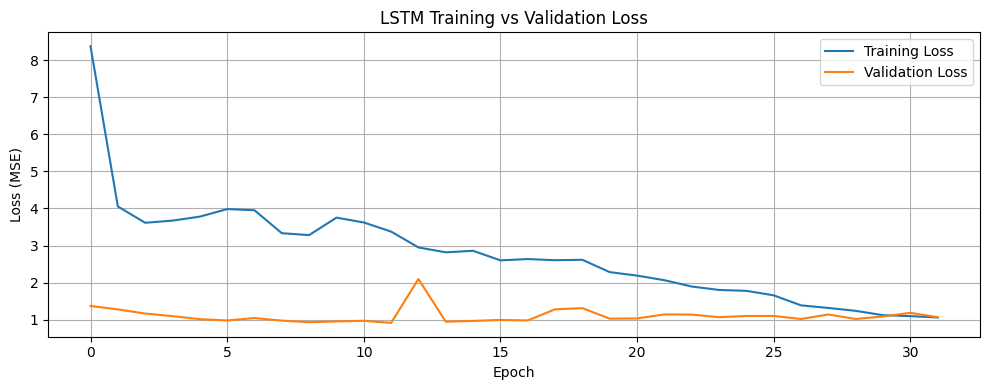

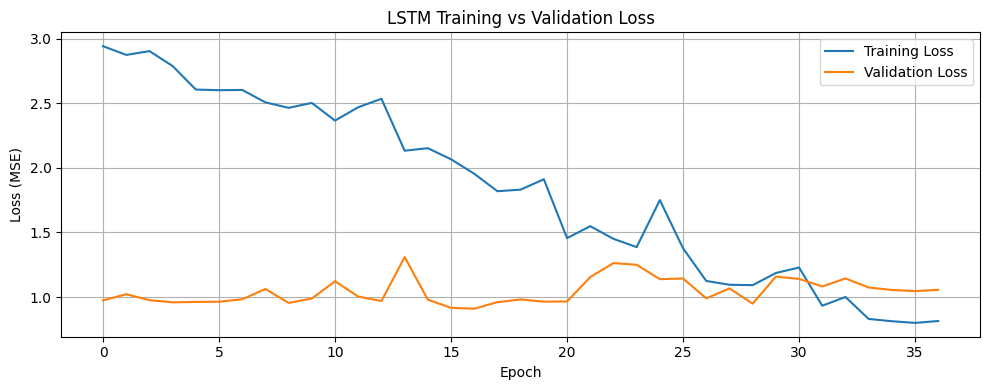

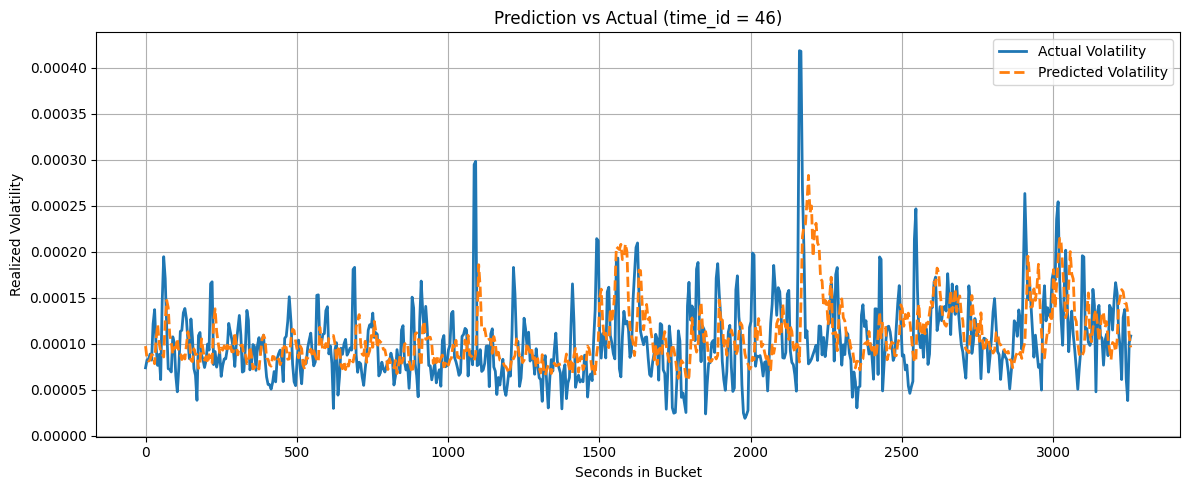

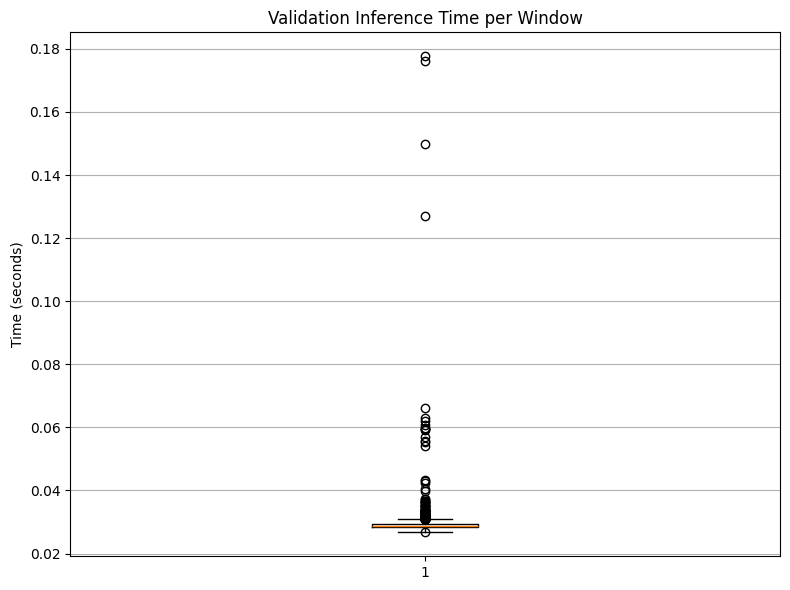

,time_id,start_time,y_true,y_pred,spike_prob,expert_normal,expert_spike,inference_time
0,46,0.0,0.000074,0.000097,0.415310,0.000089,0.000109,0.127066
1,46,5.0,0.000082,0.000083,0.403986,0.000073,0.000099,0.029910
2,46,10.0,0.000083,0.000081,0.413831,0.000072,0.000094,0.028049
3,46,15.0,0.000089,0.000082,0.362983,0.000068,0.000106,0.027896
4,46,20.0,0.000082,0.000088,0.334656,0.000071,0.000122,0.027829
5,46,25.0,0.000121,0.000087,0.380540,0.000074,0.000109,0.027776
6,46,30.0,0.000137,0.000078,0.374411,0.000056,0.000115,0.028408
7,46,35.0,0.000096,0.000105,0.333700,0.000087,0.000140,0.027737
8,46,40.0,0.000076,0.000121,0.375416,0.000118,0.000125,0.027610
9,46,45.0,0.000088,0.000101,0.382736,0.000088,0.000121,0.027723


In [10]:
util.plot_training_loss(history_lstm_moe_stage_1)
util.plot_training_loss(history_lstm_moe_stage_2)

util.plot_prediction_vs_actual(
    val_df_lstm_moe_staged,
    time_id=val_df_lstm_moe_staged['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(val_df_lstm_moe_staged)

display(val_df_lstm_moe_staged.head(10))

val_df_lstm_moe_staged.to_csv('out/val_df/moe_staged.csv', index=False)


In [15]:
K.clear_session()
gc.collect()

0

## In Sample Evaluation

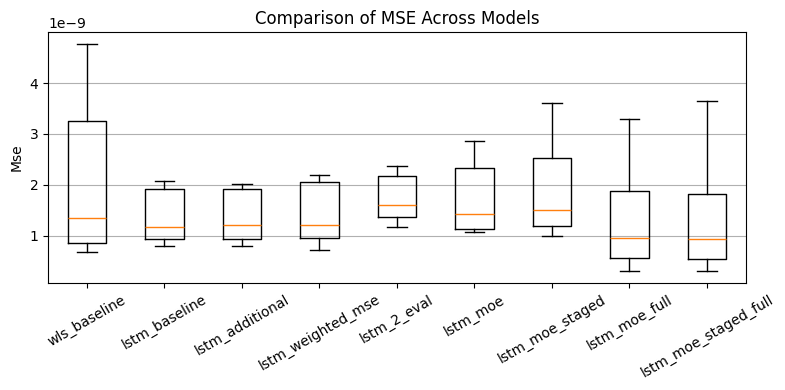

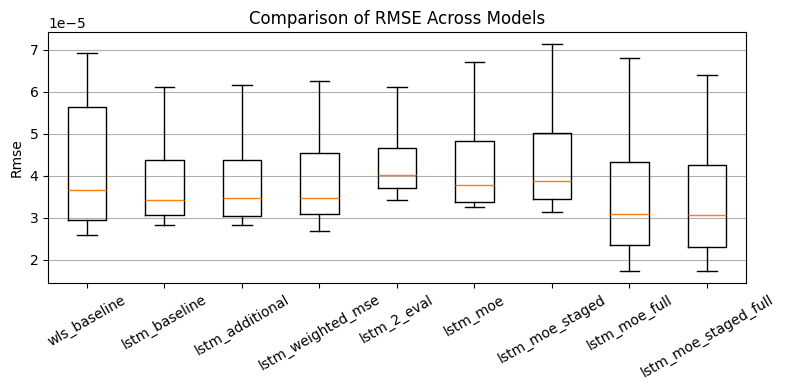

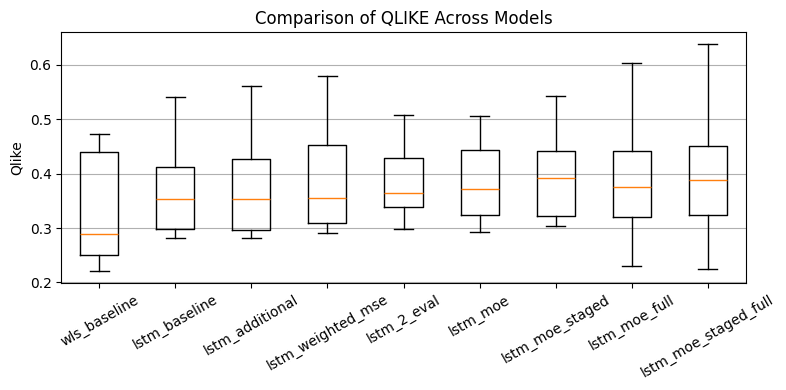

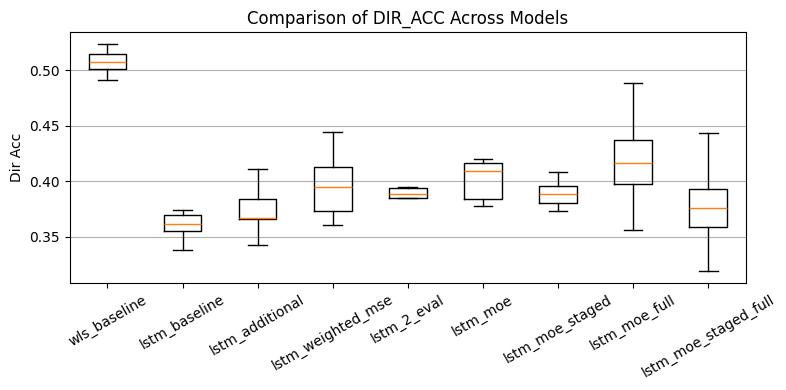

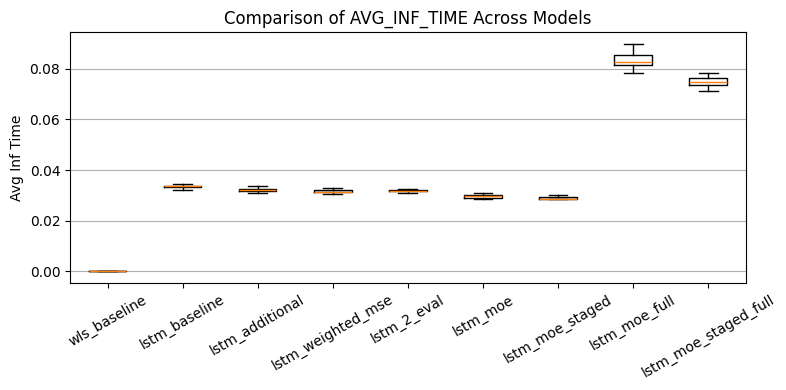

In [13]:
importlib.reload(util)

test_df_wls = pd.read_csv('out/val_df/wls.csv')
val_df_lstm_baseline = pd.read_csv('out/val_df/baseline.csv')
val_df_lstm_features = pd.read_csv('out/val_df/additional_features.csv')
val_df_lstm_weighted_mse = pd.read_csv('out/val_df/weighted_mse.csv')
val_df_lstm_2_eval = pd.read_csv('out/val_df/staged.csv')
val_df_lstm_moe = pd.read_csv('out/val_df/moe.csv')
val_df_lstm_moe_staged = pd.read_csv('out/val_df/moe_staged.csv')

val_df_lstm_moe_full = pd.read_csv('out/val_df/moe_full.csv')
val_df_lstm_moe_staged_full = pd.read_csv('out/val_df/moe_staged_full.csv')


metrics_by_model = {}
for name, val_df in [
    ('wls_baseline', test_df_wls),
    ('lstm_baseline', val_df_lstm_baseline),
    ('lstm_additional', val_df_lstm_features),
    ('lstm_weighted_mse', val_df_lstm_weighted_mse),
    ('lstm_2_eval', val_df_lstm_2_eval),
    ('lstm_moe', val_df_lstm_moe),
    ('lstm_moe_staged', val_df_lstm_moe_staged),
    ('lstm_moe_full', val_df_lstm_moe_full),
    ('lstm_moe_staged_full', val_df_lstm_moe_staged_full)
]:
    metrics_by_model[name] = util.compute_metrics_by_time_id(val_df)

import matplotlib.pyplot as plt
metrics = ['mse', 'rmse', 'qlike', 'dir_acc', 'avg_inf_time']
for metric in metrics:
    data = [metrics_by_model[name][metric].dropna() for name in metrics_by_model]
    plt.figure(figsize=(8, 4))
    plt.boxplot(data, labels=list(metrics_by_model.keys()), showfliers=False)
    plt.title(f'Comparison of {metric.upper()} Across Models')
    plt.ylabel(metric.replace('_',' ').title())
    plt.xticks(rotation=30)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


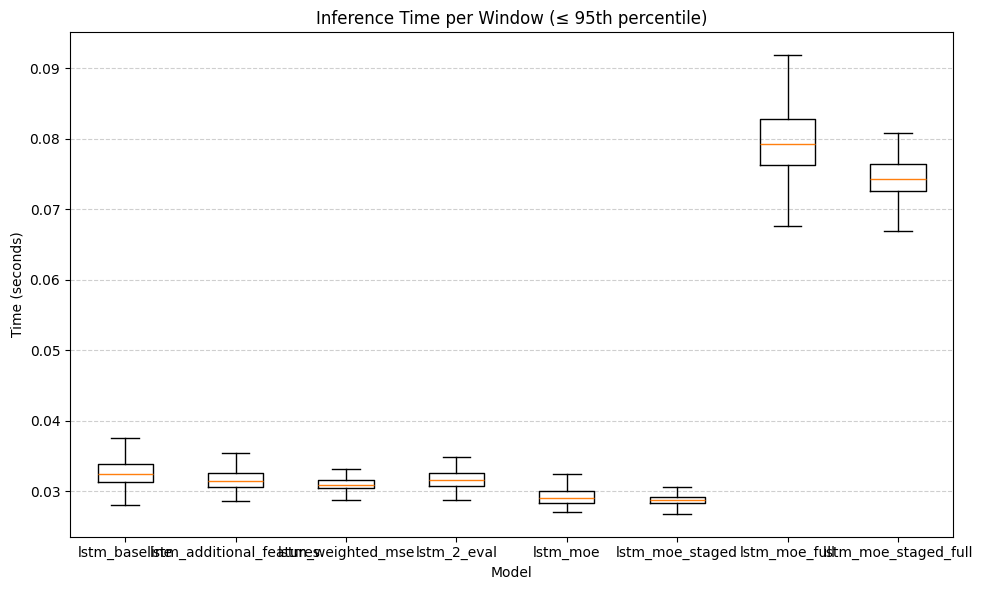

In [14]:
# Create a dictionary of DataFrames for each model
val_dfs = {
    'lstm_baseline': val_df_lstm_baseline,
    'lstm_additional_features': val_df_lstm_features,
    'lstm_weighted_mse': val_df_lstm_weighted_mse,
    'lstm_2_eval': val_df_lstm_2_eval,
    'lstm_moe': val_df_lstm_moe,
    'lstm_moe_staged': val_df_lstm_moe_staged,
    'lstm_moe_full': val_df_lstm_moe_full,
    'lstm_moe_staged_full': val_df_lstm_moe_staged_full
}

util.plot_side_by_side_inference_boxplots(val_dfs,
                                     inference_col='inference_time',
                                     percentile=95)

## Out of Sample Evaluation

### Highly Correlated Stocks: ID-104919

In [ ]:
# folder_path = "data"
# feature_path = os.path.join(folder_path, "order_book_feature.parquet")
# target_path = os.path.join(folder_path, "order_book_target.parquet")

# feature_df = pd.read_parquet(feature_path, engine='pyarrow')
# target_df = pd.read_parquet(target_path, engine='pyarrow')
# combined_df = pd.concat([feature_df, target_df], axis=0)
# combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# df_high_cor_stock = combined_df[combined_df["stock_id"] == 104919].copy()

# snapshot_features_df_high_cor = util.create_snapshot_features(df_high_cor_stock)
# snapshot_features_df_high_cor = snapshot_features_df_high_cor.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# subset_time_ids = snapshot_features_df_high_cor['time_id'].unique()[:10]
# subset_snapshot_df_high_cor = snapshot_features_df_high_cor[snapshot_features_df_high_cor['time_id'].isin(subset_time_ids)].copy()

In [ ]:
# model_path  = 'out/lstm/advanced.h5'
# scaler_path = 'out/lstm/advanced_scalers.pkl'

# basic_features = ["wap", "spread_pct", "imbalance",
#                   "depth_ratio", "log_return", "log_wap_change",
#                   "rolling_std_logret", "spread_zscore",
#                   "volume_imbalance"]

# val_df_oos_high_cor, oos_metrics_high_cor = util.out_of_sample_evaluation(
#     model_path, scaler_path,
#     subset_snapshot_df_high_cor,
#     feature_cols=basic_features
# )

# print("Out-of-Sample Metrics:", oos_metrics_high_cor)
# print(val_df_oos_high_cor.head())


### Lowly Correlated Stocks: ID-22753

In [ ]:
# folder_path = "data"
# feature_path = os.path.join(folder_path, "order_book_feature.parquet")
# target_path = os.path.join(folder_path, "order_book_target.parquet")

# feature_df = pd.read_parquet(feature_path, engine='pyarrow')
# target_df = pd.read_parquet(target_path, engine='pyarrow')
# combined_df = pd.concat([feature_df, target_df], axis=0)
# combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# df_low_cor_stock = combined_df[combined_df["stock_id"] == 22753].copy()

# snapshot_features_df_low_cor = util.create_snapshot_features(df_low_cor_stock)
# snapshot_features_df_low_cor = snapshot_features_df_low_cor.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# subset_time_ids = snapshot_features_df_low_cor['time_id'].unique()[:10]
# subset_snapshot_df_low_cor = snapshot_features_df_low_cor[snapshot_features_df_low_cor['time_id'].isin(subset_time_ids)].copy()

In [ ]:
# model_path  = 'out/lstm/advanced.h5'
# scaler_path = 'out/lstm/advanced_scalers.pkl'
# basic_features = ["wap", "spread_pct", "imbalance",
#                   "depth_ratio", "log_return", "log_wap_change",
#                   "rolling_std_logret", "spread_zscore",
#                   "volume_imbalance"]

# val_df_oos_low_cor, oos_metrics_low_cor = util.out_of_sample_evaluation(
#     model_path, scaler_path,
#     subset_snapshot_df_low_cor,
#     feature_cols=basic_features
# )

# print("Out-of-Sample Metrics:", oos_metrics_low_cor)
# print(val_df_oos_low_cor.head())

In [ ]:
# insample_adv = metric_df.loc[metric_df['model'] == 'lstm_advanced'].iloc[0].to_dict()

# comparison_df = pd.DataFrame([
#     {'dataset': 'in_sample',             **insample_adv},
#     {'dataset': 'out_sample_highcor',   **oos_metrics_high_cor},
#     {'dataset': 'out_sample_lowcor',    **oos_metrics_low_cor},
# ]).set_index('dataset')

# display(comparison_df)
